# Prediction on the final Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import preprocessing
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score, mean_absolute_error

/Users/leforestierlucas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [124]:
df = pd.read_csv("../clean_data/final_df.csv", index_col= 0)
df.drop(["Company"], axis = 1, inplace = True)
df.rename({"Value":"CompanySpend", "Spendings":"TotalSpend"}, axis=1, inplace=True)
df= pd.get_dummies(df, columns=["Device", "Market", "SubMarket"], drop_first=True)
for column in df.columns:
    if df[column].dtype == 'bool':
        df[column] = df[column].astype(int)
df

,Year,CompanySpend,TotalSpend,MarketSpends,SubMarketSpends,DevSpends,Cogs,Cogs_1,Cogs_2,Revenue,...,SubMarket_Other Peripherals,SubMarket_Other Storage,SubMarket_Other Wired,SubMarket_Other Wireless,SubMarket_Power & Energy,SubMarket_STB,SubMarket_TV,SubMarket_Tablet PCs,SubMarket_Test & Measurement,SubMarket_Video Games
0,2018,7.466000,200.530,11486.855,2038.700,3990.996,19059.000000,17278.000000,17270.0,27662.00,...,0,0,0,0,1,0,0,0,0,0
1,2019,8.471900,189.490,10750.418,1947.505,3800.001,19018.000000,19059.000000,17278.0,27978.00,...,0,0,0,0,1,0,0,0,0,0
2,2020,8.661150,195.081,10966.167,2004.751,3786.004,18123.000000,19018.000000,19059.0,26134.00,...,0,0,0,0,1,0,0,0,0,0
3,2021,10.090255,240.245,13599.835,2321.554,4785.001,19407.000000,18123.000000,19018.0,28945.00,...,0,0,0,0,1,0,0,0,0,0
4,2022,10.040442,257.635,15244.412,2525.705,5469.003,19712.000000,19407.000000,18123.0,29446.00,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25911,2020,0.809700,454.000,25838.124,4852.175,11956.010,2445.000000,2385.000000,2237.0,4448.00,...,0,0,0,1,0,0,0,0,0,0
25912,2021,1.271038,584.000,33129.151,5885.459,15765.008,2999.000000,2445.000000,2385.0,5627.00,...,0,0,0,1,0,0,0,0,0,0
25913,2022,1.229600,555.000,37356.594,5729.355,17307.004,3157.000000,2999.000000,2445.0,5781.00,...,0,0,0,1,0,0,0,0,0,0
25914,2023,1.182734,474.999,28959.587,4701.997,16419.001,7385.362857,3157.000000,2999.0,4536.76,...,0,0,0,1,0,0,0,0,0,0


In [125]:
X_train = df[(df.Year<=2022)]
X_test = df[(df.Year>=2023)]
y_train = X_train.pop("CompanySpend")
y_test = X_test.pop("CompanySpend")
X_train.drop(["Year"], axis=1, inplace=True)
X_test.drop(["Year"], axis=1, inplace=True)

<ipython-input-125-1d2759a4246b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(["Year"], axis=1, inplace=True)
<ipython-input-125-1d2759a4246b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(["Year"], axis=1, inplace=True)


### Linear Regression

In [62]:
X_bis = sm.add_constant(np.asarray(X_train).astype('float64'))
est = sm.OLS(np.asarray(y_train).astype('float64'), X_bis)
reg = est.fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     79.12
Date:                Tue, 28 Nov 2023   Prob (F-statistic):               0.00
Time:                        10:58:49   Log-Likelihood:                -85481.
No. Observations:               14460   AIC:                         1.711e+05
Df Residuals:                   14410   BIC:                         1.714e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.5011      3.749     -1.201      0.2

In [63]:
X_bis_test = sm.add_constant(np.asarray(X_test).astype('float64'))
mean_absolute_error(np.asarray(y_test).astype('float64'), reg.predict(X_bis_test))

24.91385379409942

### CART

In [126]:
model_cart = DecisionTreeRegressor(max_depth=6, min_samples_leaf=5)
model_cart.fit(X_train, y_train)
r2_score(y_train, model_cart.predict(X_train))

0.8362972728038424

In [127]:
mean_absolute_error(y_test, model_cart.predict(X_test))

14.366684425086914

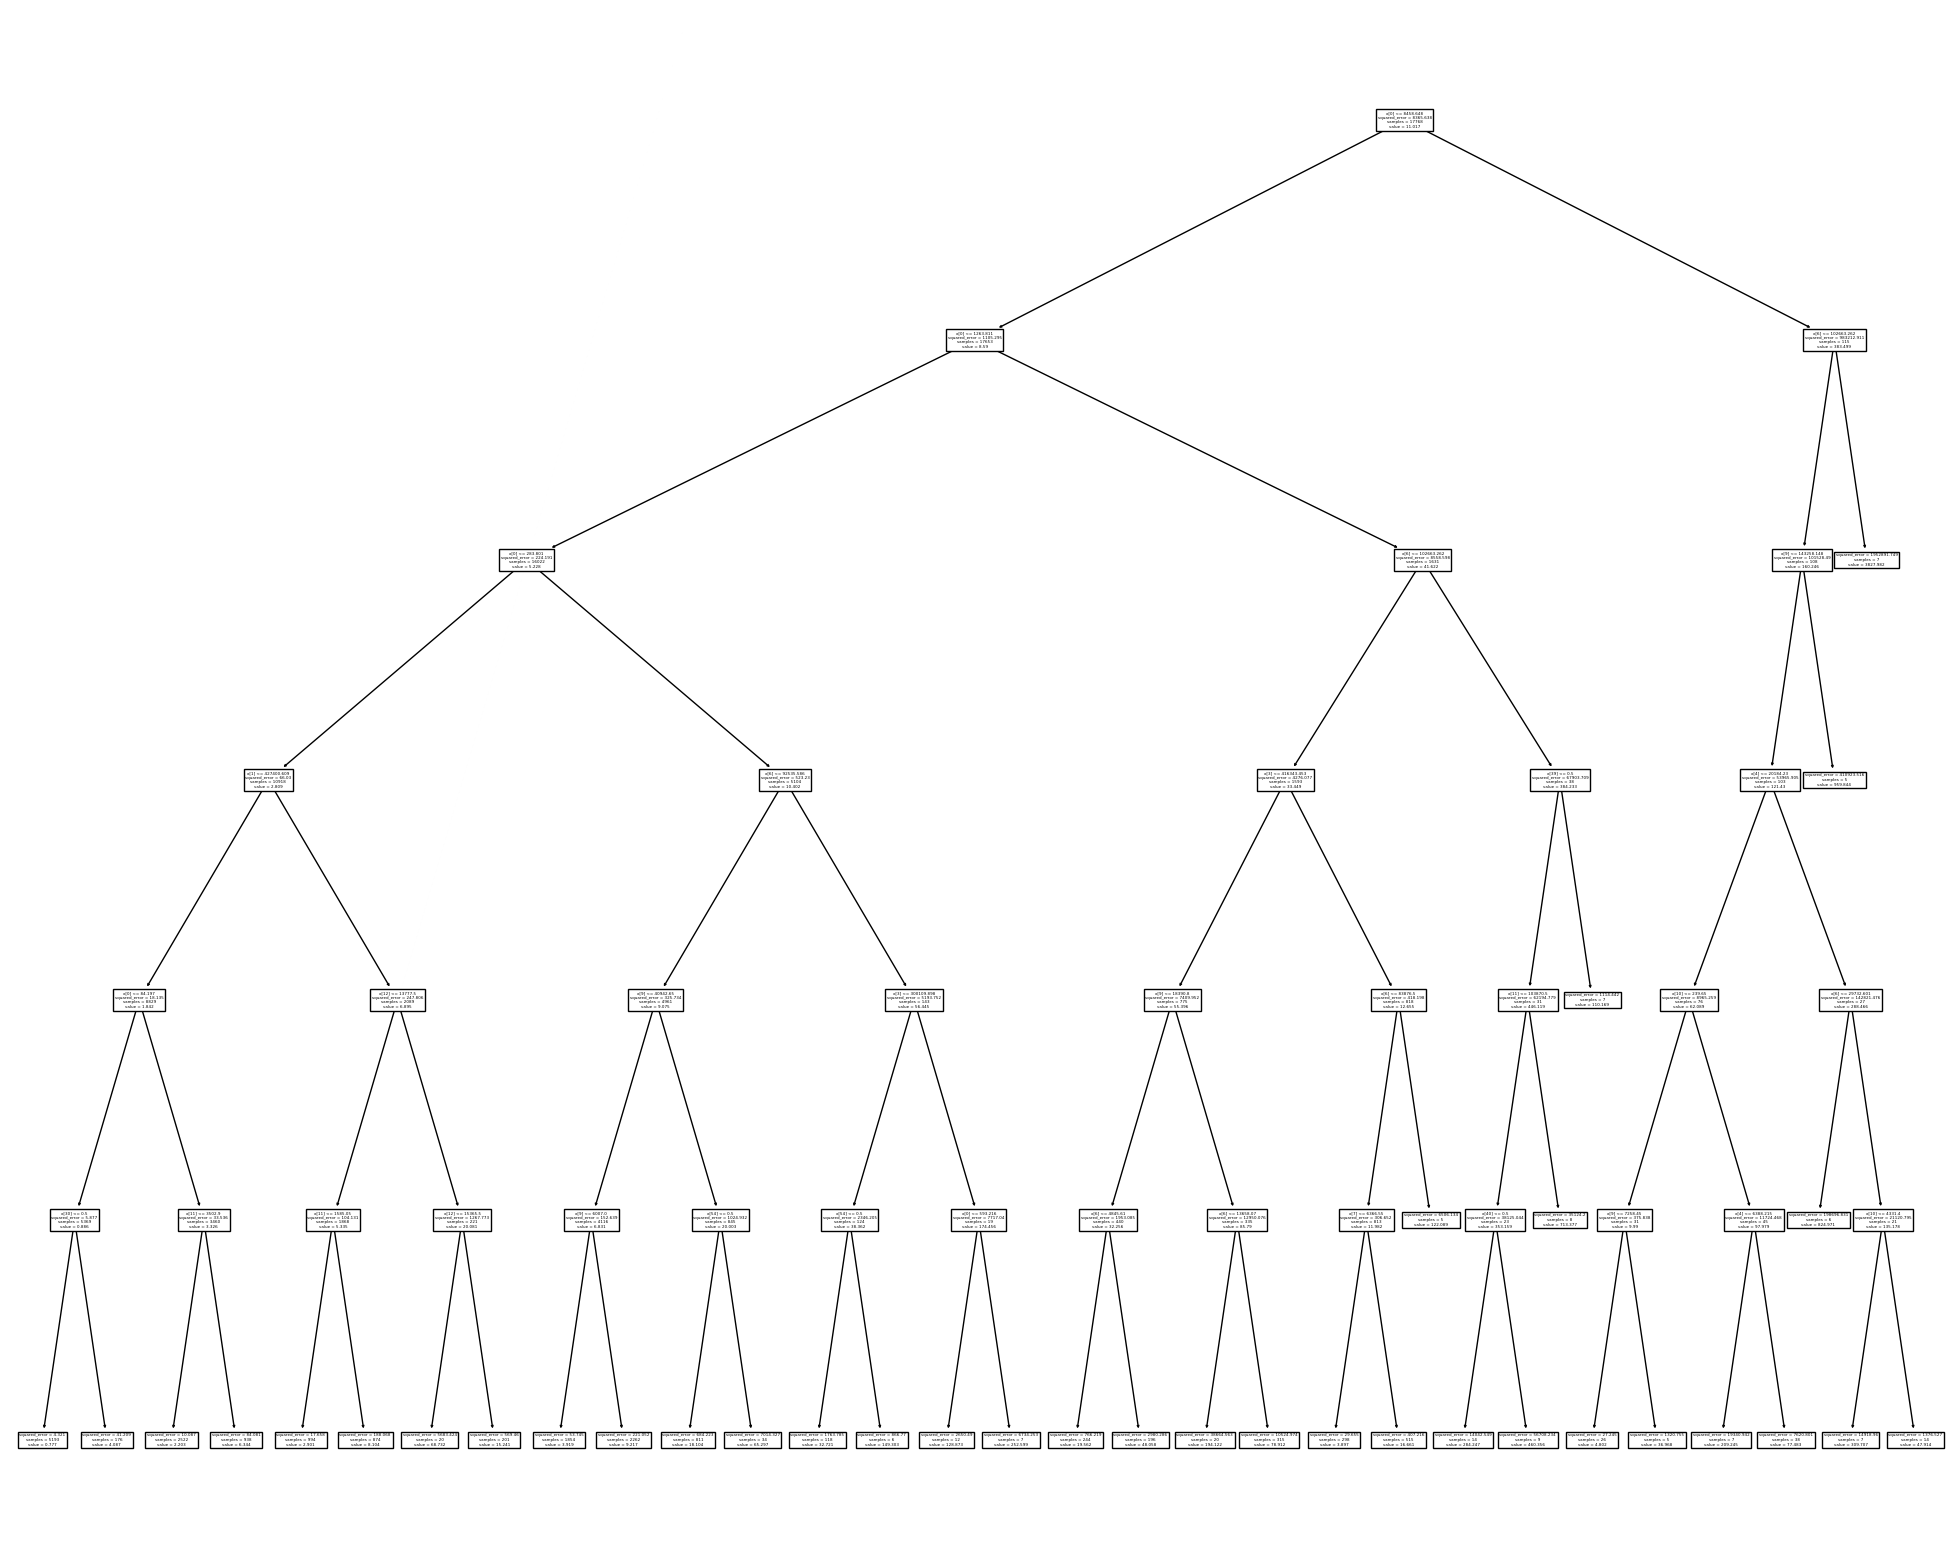

In [27]:
fig = plt.figure(figsize=(25,20))
plot_tree(model_cart)
plt.show()

### Features Analysis

In [29]:
df = pd.read_csv("../clean_data/final_df.csv", index_col= 0)
#df.drop("Company", axis =1, inplace = True)
df

,Company,Device,Market,SubMarket,Year,Value,Region,Spendings,MarketSpends,SubMarketSpends,DevSpends,Cogs,Cogs_1,Cogs_2,Revenue,Revenue_1,Revenue_2,Ebitda,Ebitda_1,Ebitda_2
0,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2018,7.951500,AmericasAsia & Oceania (exc. Japan)EMEAJapan,82.904,11486.855,926.369,3990.996,19059.000000,17278.000000,17270.0,27662.00,25196.00,24929.0,3227.000000,2929.000000,2987.0
1,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2019,8.616500,AmericasAsia & Oceania (exc. Japan)EMEAJapan,84.255,10750.418,905.298,3800.001,19018.000000,19059.000000,17278.0,27978.00,27662.00,25196.0,3347.000000,3227.000000,2929.0
2,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2020,8.565350,AmericasAsia & Oceania (exc. Japan)EMEAJapan,85.306,10966.167,942.751,3786.004,18123.000000,19018.000000,19059.0,26134.00,27978.00,27662.0,2668.000000,3347.000000,3227.0
3,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2021,12.353845,AmericasAsia & Oceania (exc. Japan)EMEAJapan,122.722,13599.835,1128.090,4785.001,19407.000000,18123.000000,19018.0,28945.00,26134.00,27978.0,4641.000000,2668.000000,3347.0
4,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2022,13.879158,AmericasAsia & Oceania (exc. Japan)EMEAJapan,138.207,15244.412,1221.082,5469.003,19712.000000,19407.000000,18123.0,29446.00,28945.00,26134.0,4477.000000,4641.000000,2668.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27696,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2020,0.809700,AmericasAsia & Oceania (exc. Japan)EMEAJapanAm...,454.000,25838.124,4852.175,11956.010,2445.000000,2385.000000,2237.0,4448.00,4485.00,4218.0,831.000000,899.000000,817.0
27697,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2021,1.271038,AmericasAsia & Oceania (exc. Japan)EMEAJapanAm...,584.000,33129.151,5885.459,15765.008,2999.000000,2445.000000,2385.0,5627.00,4448.00,4485.0,1198.000000,831.000000,899.0
27698,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2022,1.229600,AmericasAsia & Oceania (exc. Japan)EMEAJapanAm...,555.000,37356.594,5729.355,17307.004,3157.000000,2999.000000,2445.0,5781.00,5627.00,4448.0,1140.000000,1198.000000,831.0
27699,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2023,1.182734,AmericasAsia & Oceania (exc. Japan)EMEAJapanAm...,474.999,28959.587,4701.997,16419.001,7385.362857,3157.000000,2999.0,4536.76,5781.00,5627.0,3668.885714,1140.000000,1198.0


In [20]:
new_df = pd.read_csv("../clean_data/newtarget_df.csv", index_col= 0)
new_df.drop("Company", axis =1, inplace = True)
num_features_names = list(new_df.columns)[5:]
print(num_features_names)
new_df


['Target', 'LogDiffSpendings', 'LogDiffMarketSpends', 'LogDiffSubMarketSpends', 'LogDiffDevSpends', 'LogDiffCogs', 'LogDiffRevenue', 'LogDiffEbitda', 'LogDiffCogs_1', 'LogDiffRevenue_1', 'LogDiffEbitda_1']


,Device,Market,SubMarket,Year,Region,Target,LogDiffSpendings,LogDiffMarketSpends,LogDiffSubMarketSpends,LogDiffDevSpends,LogDiffCogs,LogDiffRevenue,LogDiffEbitda,LogDiffCogs_1,LogDiffRevenue_1,LogDiffEbitda_1
0,Amplifier/Comparator,Industrial,Manufacturing Equipment,2019,AmericasAsia & Oceania (exc. Japan)EMEAJapan,0.071659,0.015973,-0.066253,-0.022983,-0.049027,-0.002153,0.011358,0.036500,0.098100,0.093371,0.096860
1,Amplifier/Comparator,Industrial,Manufacturing Equipment,2020,AmericasAsia & Oceania (exc. Japan)EMEAJapan,-0.005333,0.012252,0.019868,0.040494,-0.003689,-0.048201,-0.068179,-0.226659,-0.002153,0.011358,0.036500
2,Amplifier/Comparator,Industrial,Manufacturing Equipment,2021,AmericasAsia & Oceania (exc. Japan)EMEAJapan,0.333657,0.360138,0.215225,0.179305,0.234120,0.068448,0.102157,0.553441,-0.048201,-0.068179,-0.226659
3,Amplifier/Comparator,Industrial,Manufacturing Equipment,2022,AmericasAsia & Oceania (exc. Japan)EMEAJapan,0.108157,0.117925,0.114147,0.079144,0.133584,0.015593,0.017160,-0.035969,0.068448,0.102157,0.553441
4,Amplifier/Comparator,Industrial,Manufacturing Equipment,2023,AmericasAsia & Oceania (exc. Japan)EMEAJapan,0.146973,0.045711,0.068025,-0.009323,-0.063393,-0.690697,0.088614,0.260177,0.015593,0.017160,-0.035969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18671,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2020,AmericasAsia & Oceania (exc. Japan)EMEAJapanAm...,0.058855,-0.004677,0.153879,0.049009,0.085060,0.024836,-0.008282,-0.078562,0.064036,0.061363,0.095532
18672,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2021,AmericasAsia & Oceania (exc. Japan)EMEAJapanAm...,0.227076,0.251314,0.248554,0.193021,0.276539,0.204158,0.235075,0.365411,0.024836,-0.008282,-0.078562
18673,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2022,AmericasAsia & Oceania (exc. Japan)EMEAJapanAm...,-0.018415,-0.050844,0.120092,-0.026877,0.093313,0.051327,0.026996,-0.049583,0.204158,0.235075,0.365411
18674,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2023,AmericasAsia & Oceania (exc. Japan)EMEAJapanAm...,-0.021244,-0.155353,-0.254600,-0.197578,-0.052669,0.849697,-0.242316,1.168255,0.051327,0.026996,-0.049583


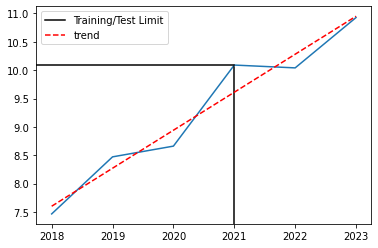

In [22]:
plt.plot(list(df.Year)[:6], list(df.Value)[:6])
coefficients = np.polyfit(list(df.Year)[:6], list(df.Value)[:6], 1)
tendance = np.poly1d(coefficients)
tendance_y = tendance(list(df.Year)[:6])
plt.axvline(x=2021, ymax=0.72, color='k',label='Training/Test Limit')
plt.axhline(y=10.09, xmax=0.59, color='k')
# Tracer la tendance en ligne pointillée rouge
plt.plot(list(df.Year)[:6], tendance_y, 'r--', label='trend')
#plt.axhline(y=10, color='g', linestyle=':', label=f'Ligne arrêtée à y')
#plt.plot(list(new_df.Year)[:6], [0.08, 0.078, 0.076, 0.074, 0.072, 0.070], linestyle='--', color = "r", label = "trend")
plt.legend()

<AxesSubplot:>

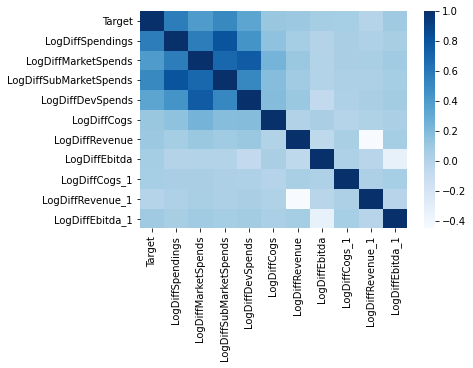

In [17]:
import seaborn as sn
corr_df = new_df.iloc[:, 4:]
sn.heatmap(corr_df.corr(), cmap="Blues")

### XGBoost

In [12]:
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [129]:
features = [x for x in list(df.columns) if not (x.endswith("1") or x.endswith("2"))]
features = ['Device',
 'Market',
 'SubMarket',
 'Year',
 'Value',
 'Spendings',
 'DevSpends',
 'MarketSpends',
 'SubMarketSpends',
 'Cogs',
 'Revenue',
 'Ebitda']

In [117]:
first_df = df[(df.Year <= 2022)]
y_train = np.array(first_df.Value)
X_train = first_df.drop("Value", axis = 1)
second_df = df[(df.Year >= 2023)]
y_test = np.array(second_df.Value)
X_test = second_df.drop("Value", axis = 1)


In [118]:
cat = ["Device", "Market", "SubMarket"]
full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat)], remainder='passthrough')
encoder = full_pipeline.fit(X_train)

In [136]:
X_train

,Device,Market,SubMarket,Year,Spendings,MarketSpends,SubMarketSpends,DevSpends,Cogs,Cogs_1,Cogs_2,Revenue,Revenue_1,Revenue_2,Ebitda,Ebitda_1,Ebitda_2
0,Amplifier/Comparator,Industrial,Power & Energy,2018,200.530,11486.855,2038.700,3990.996,19059.00,17278.00,17270.00,27662.0,25196.0,24929.0,3227.0,2929.0,2987.0
1,Amplifier/Comparator,Industrial,Power & Energy,2019,189.490,10750.418,1947.505,3800.001,19018.00,19059.00,17278.00,27978.0,27662.0,25196.0,3347.0,3227.0,2929.0
2,Amplifier/Comparator,Industrial,Power & Energy,2020,195.081,10966.167,2004.751,3786.004,18123.00,19018.00,19059.00,26134.0,27978.0,27662.0,2668.0,3347.0,3227.0
3,Amplifier/Comparator,Industrial,Power & Energy,2021,240.245,13599.835,2321.554,4785.001,19407.00,18123.00,19018.00,28945.0,26134.0,27978.0,4641.0,2668.0,3347.0
4,Amplifier/Comparator,Industrial,Power & Energy,2022,257.635,15244.412,2525.705,5469.003,19712.00,19407.00,18123.00,29446.0,28945.0,26134.0,4477.0,4641.0,2668.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25930,Voltage Regulator/Reference,Consumer,Appliance,2018,209.215,5264.952,441.264,10820.000,518.61,438.11,337.83,1092.6,883.9,660.6,144.8,96.7,70.8
25931,Voltage Regulator/Reference,Consumer,Appliance,2019,260.260,5174.397,511.580,10981.006,658.36,518.61,438.11,1214.0,1092.6,883.9,124.5,144.8,96.7
25932,Voltage Regulator/Reference,Consumer,Appliance,2020,282.999,5679.186,558.000,11956.010,758.24,658.36,518.61,1430.4,1214.0,1092.6,184.4,124.5,144.8
25933,Voltage Regulator/Reference,Consumer,Appliance,2021,399.001,7289.565,722.000,15765.008,1013.47,758.24,658.36,1565.0,1430.4,1214.0,43.4,184.4,124.5


In [ ]:
tscv = TimeSeriesSplit(n_splits=5, test_size=1000, gap = 3)

num_estimators=[20, 30, 40, 50, 60]
max_depth = [3, 4, 5]
alpha = [0.5, 0.7, 1, 1.5]
lam = [0.5, 0.7, 1, 1.5]


init_lr = 0.3
def lr_decay(epoch):
    lr = init_lr*0.9**epoch   # *0.99 0.9 0.995 0.999
    return lr

lrs = xgboost.callback.LearningRateScheduler(lr_decay)

score = []
for num_esti in num_estimators:
    for md in max_depth:
        for a in alpha:
            for l in lam:
                res = [num_esti, md, a, l]
                rmse = []
                for train_index, test_index in tscv.split(X_train):
                    cv_train, cv_val = encoder.transform(X_train.iloc[train_index]), encoder.transform(X_train.iloc[test_index])
                    cv_y_train, cv_y_val = y_train[train_index], y_train[test_index]
                    #init_lr = eta
                    #callbacks = xgb.callback.LearningRateScheduler(lr_decay)
                    model = XGBRegressor(n_estimators = num_esti, max_depth = md, reg_alpha = a, reg_lambda = l, eta = 0.3)
                    model.fit(cv_train, cv_y_train) #, callbacks=[callbacks])
                    rmse.append(np.sqrt(mean_squared_error(model.predict(cv_val), cv_y_val)))
                res.append(np.mean(rmse))
                score.append(res)

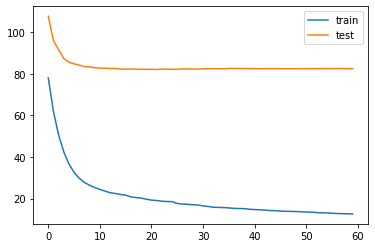

R2 score of the train set : 0.9835535547560731
R2 score of the train set : 0.23198601212138115
OSR2 : 0.5786747642607979


In [65]:
#score = pd.DataFrame(score, columns = ["num_estimators", "max_depth", "alpha", "lambda","rmse"])
#score.sort_values(by=['rmse'], ascending=False, inplace = True)
#best_params = list(score.iloc[0, :])[:-1]
#print(score.iloc[0, :])

evalset = [(encoder.transform(X_train), y_train), (encoder.transform(X_test),y_test)]
model = XGBRegressor(n_estimators = 60, max_depth = 4, reg_alpha = 0.7, reg_lambda = 0.5, eta = 0.3)
#init_lr = eta = best_params[5]
#callbacks = xgb.callback.LearningRateScheduler(lr_decay)
model.fit(encoder.transform(X_train), y_train, eval_set = evalset, verbose = 0)# , callbacks=[callbacks])
results = model.evals_result()
pyplot.plot(results['validation_0']['rmse'], label='train')
pyplot.plot(results['validation_1']['rmse'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print(f"R2 score of the train set : {r2_score(model.predict(encoder.transform(X_train)), y_train)}")
print(f"R2 score of the train set : {r2_score(model.predict(encoder.transform(X_test)), y_test)}")

osr = 1 - (sum([(list(model.predict(encoder.transform(X_test)))[k] - y_test[k])**2 for k in range(len(y_test))]))/(sum([(np.mean(y_train) - y_test[k])**2 for k in range(len(y_test))]))
print(f"OSR2 : {osr}")

In [66]:
from sklearn.metrics import mean_absolute_error

print(f"MAE score of the train set : {mean_absolute_error(model.predict(encoder.transform(X_train)), y_train)}")
print(f"MAE score of the test set : {mean_absolute_error(model.predict(encoder.transform(X_test)), y_test)}")

MAE score of the train set : 5.434610078476337
MAE score of the test set : 13.487196770514362


In [74]:
def osr2(x, y, train):
    return 1 - (sum([(list(x)[k] - list(y)[k])**2 for k in range(len(y))]))/(sum([(np.mean(train) - list(y)[k])**2 for k in range(len(y))]))

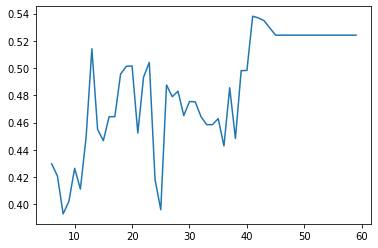

In [23]:
from sklearn.feature_selection import SelectFromModel
from numpy import sort
thresholds = sort(model.feature_importances_)
score_r2 = []
nb_features = []
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(encoder.transform(X_train))
	# train model
	selection_model = XGBRegressor(n_estimators = int(best_params[0]), max_depth = int(best_params[1]), reg_alpha = best_params[2], reg_lambda = best_params[3], eta = 0.3)
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(encoder.transform(X_test))
	r2 = r2_score(selection_model.predict(select_X_test), y_test)
	score_r2.append(r2)
	nb_features.append(select_X_train.shape[1])
	#print("Thresh=%.3f, n=%d, R2: %.4f" % (thresh, select_X_train.shape[1], r2))
plt.plot(nb_features[:-5], score_r2[:-5])
plt.show()

### RF

In [76]:
from sklearn.ensemble import RandomForestRegressor
tscv = TimeSeriesSplit(n_splits=5, test_size=1000, gap = 3)

num_estimators=[30, 50, 60, 70, 100, 120, 150]
min_samples_split = [2, 3, 5, 7]
min_samples_leaf = [1, 3, 5]
max_features = ["sqrt", "log2", 1]


score = []
for num_esti in num_estimators:
    for mss in min_samples_split:
        for msl in min_samples_leaf:
            for mf in max_features:
                res = [num_esti, mss, msl, mf]
                rmse = []
                for train_index, test_index in tscv.split(X_train):
                    cv_train, cv_val = encoder.transform(X_train.iloc[train_index]), encoder.transform(X_train.iloc[test_index])
                    cv_y_train, cv_y_val = y_train[train_index], y_train[test_index]
                    #init_lr = eta
                    #callbacks = xgb.callback.LearningRateScheduler(lr_decay)
                    model = RandomForestRegressor(n_estimators = num_esti, min_samples_split = mss, min_samples_leaf = msl, max_features = mf)
                    model.fit(cv_train, cv_y_train) #, callbacks=[callbacks])
                    rmse.append(np.sqrt(mean_squared_error(model.predict(cv_val), cv_y_val)))
                res.append(np.mean(rmse))
                score.append(res)

In [120]:
#score = pd.DataFrame(score, columns = ["num_estimators", "min_samples_split", "min_samples_leaf", "max_features","rmse"])
#score.sort_values(by=['rmse'], ascending=False, inplace = True)
#best_params = list(score.iloc[0, :])[:-1]
#print(score.iloc[0, :])
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 70, min_samples_split = 7, min_samples_leaf = 1, max_features = 1)
model.fit(encoder.transform(X_train), y_train)# , callbacks=[callbacks])
print(f"R2 score of the train set : {r2_score(model.predict(encoder.transform(X_train)), y_train)}")
print(f"R2 score of the test set : {r2_score(model.predict(encoder.transform(X_test)), y_test)}")
print(f"OSR2 : {osr2(model.predict(encoder.transform(X_test)), y_test, y_train)}")
print(f"MAE Test : {mean_absolute_error(model.predict(encoder.transform(X_test)), y_test)}")

R2 score of the train set : 0.16812117510882307
R2 score of the test set : -0.7989849012233878
OSR2 : 0.5545552575088519
MAE Test : 13.902395649809375


### PCA + Models

In [6]:
from sklearn.decomposition import PCA, TruncatedSVD

Elbow criteria

In [10]:
tscv = TimeSeriesSplit(n_splits=5, test_size=1000, gap = 3)

num_estimators=[50]
max_depth = [5]
alpha = [1.5]
lam = [1.5]
nb_components = [i for i in range(5, 15)]

score = []
for num_esti in num_estimators:
    for md in max_depth:
        for a in alpha:
            for l in lam:
                for nb_compo in nb_components :
                    res = [num_esti, md, a, l, nb_compo]
                    rmse = []
                    for train_index, test_index in tscv.split(X_train):
                        cv_train, cv_val = encoder.transform(X_train.iloc[train_index]), encoder.transform(X_train.iloc[test_index])
                        cv_y_train, cv_y_val = y_train[train_index], y_train[test_index]
                        #init_lr = eta
                        pca = TruncatedSVD(n_components = nb_compo)
                        train_pca = pca.fit_transform(cv_train)
                        #callbacks = xgb.callback.LearningRateScheduler(lr_decay)
                        model = XGBRegressor(n_estimators = num_esti, max_depth = md, reg_alpha = a, reg_lambda = l)
                        model.fit(train_pca, cv_y_train) #, callbacks=[callbacks])
                        rmse.append(np.sqrt(mean_squared_error(model.predict(pca.transform(cv_val)), cv_y_val)))
                    res.append(np.mean(rmse))
                    score.append(res)

num_estimators    50.00000
max_depth          5.00000
alpha              1.50000
lambda             1.50000
nb_components     11.00000
rmse              58.53721
Name: 6, dtype: float64


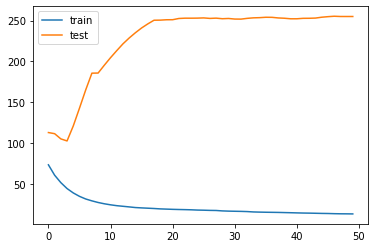

R2 score of the train set : 0.9767787905039392
R2 score of the test set : -0.01863499345159414


In [14]:
score = pd.DataFrame(score, columns = ["num_estimators", "max_depth", "alpha", "lambda", "nb_components", "rmse"])
score.sort_values(by=['rmse'], ascending=False, inplace = True)
best_params = list(score.iloc[0, :])[:-1]
print(score.iloc[0, :])

pca = TruncatedSVD(n_components = nb_compo)
pca.fit(encoder.transform(X_train))
evalset = [(pca.transform(encoder.transform(X_train)), y_train), (pca.transform(encoder.transform(X_test)),y_test)]
model = XGBRegressor(n_estimators = int(best_params[0]), max_depth = int(best_params[1]), reg_alpha = best_params[2], reg_lambda = best_params[3], eta = 0.3)
#init_lr = eta = best_params[5]
#callbacks = xgb.callback.LearningRateScheduler(lr_decay)
model.fit(pca.transform(encoder.transform(X_train)), y_train, eval_set = evalset, verbose = 0)# , callbacks=[callbacks])
results = model.evals_result()
pyplot.plot(results['validation_0']['rmse'], label='train')
pyplot.plot(results['validation_1']['rmse'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print(f"R2 score of the train set : {r2_score(model.predict(pca.transform(encoder.transform(X_train))), y_train)}")
print(f"R2 score of the test set : {r2_score(model.predict(pca.transform(encoder.transform(X_test))), y_test)}")

Kaiser Criteria

In [18]:
tscv = TimeSeriesSplit(n_splits=5, test_size=1000, gap = 3)

num_estimators=[30, 40, 50, 60]
max_depth = [3, 4, 5]
alpha = [0.7, 1, 1.5]
lam = [0.7, 1, 1.5]

pca = TruncatedSVD()
pca.fit(encoder.transform(X_train))
eigenvalues = pca.explained_variance_
nb_components = np.sum(eigenvalues > 1.0)

score = []
for num_esti in num_estimators:
    for md in max_depth:
        for a in alpha:
            for l in lam:
                res = [num_esti, md, a, l]
                rmse = []
                for train_index, test_index in tscv.split(X_train):
                    cv_train, cv_val = encoder.transform(X_train.iloc[train_index]), encoder.transform(X_train.iloc[test_index])
                    cv_y_train, cv_y_val = y_train[train_index], y_train[test_index]
                    #init_lr = eta
                    pca = TruncatedSVD(n_components = nb_components)
                    train_pca = pca.fit_transform(cv_train)
                    #callbacks = xgb.callback.LearningRateScheduler(lr_decay)
                    model = XGBRegressor(n_estimators = num_esti, max_depth = md, reg_alpha = a, reg_lambda = l, eta = 0.3)
                    model.fit(cv_train, cv_y_train) #, callbacks=[callbacks])
                    rmse.append(np.sqrt(mean_squared_error(model.predict(cv_val), cv_y_val)))
                res.append(np.mean(rmse))
                score.append(res)

num_estimators    50.000000
max_depth          4.000000
alpha              1.500000
lambda             0.700000
rmse              56.220991
Name: 69, dtype: float64


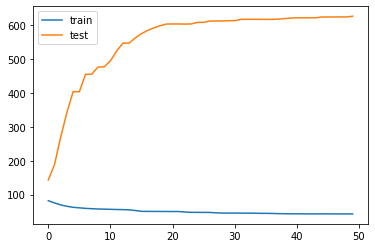

R2 score of the train set : 0.6906190922286009
R2 score of the test set : -0.05419151690776847


In [20]:
score = pd.DataFrame(score, columns = ["num_estimators", "max_depth", "alpha", "lambda", "rmse"])
score.sort_values(by=['rmse'], ascending=False, inplace = True)
best_params = list(score.iloc[0, :])[:-1]
print(score.iloc[0, :])

pca = TruncatedSVD(n_components = nb_components)
pca.fit(encoder.transform(X_train))
evalset = [(pca.transform(encoder.transform(X_train)), y_train), (pca.transform(encoder.transform(X_test)),y_test)]
model = XGBRegressor(n_estimators = int(best_params[0]), max_depth = int(best_params[1]), reg_alpha = best_params[2], reg_lambda = best_params[3], eta = 0.3)
#init_lr = eta = best_params[5]
#callbacks = xgb.callback.LearningRateScheduler(lr_decay)
model.fit(pca.transform(encoder.transform(X_train)), y_train, eval_set = evalset, verbose = 0)# , callbacks=[callbacks])
results = model.evals_result()
pyplot.plot(results['validation_0']['rmse'], label='train')
pyplot.plot(results['validation_1']['rmse'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print(f"R2 score of the train set : {r2_score(model.predict(pca.transform(encoder.transform(X_train))), y_train)}")
print(f"R2 score of the test set : {r2_score(model.predict(pca.transform(encoder.transform(X_test))), y_test)}")

### Baseline

In [67]:
baseline_df = pd.read_csv("../clean_data/final_df.csv", index_col= 0)
baseline_train = baseline_df[["Company", "Market", "SubMarket", "Device", "Year", "Spendings"]][(baseline_df.Year <= 2022)]
baseline_test = baseline_df[["Company", "Market", "SubMarket", "Device", "Year", "Spendings"]][(baseline_df.Year >= 2023)]

In [69]:
combinations = []
for ind in baseline_train.groupby(["Company", "Market", "SubMarket", "Device"]).size().reset_index().index:
    combinations.append(baseline_train.groupby(["Company", "Market", "SubMarket", "Device"]).size().reset_index().iloc[0, :-1].values)

In [71]:
r2_baseline_train = []
r2_baseline_test = []
osr2_baseline = []
mae_baseline_train = []
mae_baseline_test = []
for x in combinations :
    y_train = baseline_train[(baseline_train.Company == x[0]) & (baseline_train.Market == x[1]) & (baseline_train.SubMarket == x[2]) & (baseline_train.Device == x[3])].Spendings
    X_train = np.array([i for i in range(2018, 2023)]).reshape(-1, 1)
    X_bis = sm.add_constant(X_train)
    est = sm.OLS(y_train, X_bis)
    reg = est.fit()
    X_test = np.array([2023, 2024]).reshape(-1, 1)
    X_test_bis = sm.add_constant(X_test)
    y_test = baseline_test[(baseline_test.Company == x[0]) & (baseline_test.Market == x[1]) & (baseline_test.SubMarket == x[2]) & (baseline_test.Device == x[3])].Spendings
    r2_baseline_train.append(r2_score(reg.predict(X_bis), y_train))
    r2_baseline_test.append(r2_score(reg.predict(X_test_bis), y_test))
    mae_baseline_train.append(mean_absolute_error(reg.predict(X_bis), y_train))
    mae_baseline_test.append(mean_absolute_error(reg.predict(X_test_bis), y_test))
    osr2_baseline.append(osr2(reg.predict(X_test_bis), y_test, y_train))

print(f"The Train R2 for the baseline is : {np.mean(r2_baseline_train)}")
print(f"The Test R2 for the baseline is : {np.mean(r2_baseline_test)}")
print(f"The OR2 for the baseline is : {np.mean(osr2_baseline)}")

print(f"The Train MAE for the baseline is : {np.mean(mae_baseline_train)}")
print(f"The Test MAE for the baseline is : {np.mean(mae_baseline_test)}")

The Train R2 for the baseline is : 0.6406643140498136
The Test R2 for the baseline is : -15.711267732544027
The OR2 for the baseline is : 0.8656162143161908
The Train MAE for the baseline is : 12.849960000005384
The Test MAE for the baseline is : 32.918050000043486


In [25]:
y_test

5    291.701
6    322.803
Name: Spendings, dtype: float64

### Other Baseline

In [72]:
baseline_df2 = pd.read_csv("../clean_data/final_df.csv", index_col= 0)
baseline_df2["Predict"] = baseline_df2.Spendings.shift(1)
baseline_df2 = baseline_df2[(baseline_df2.Year >= 2023)][["Spendings", "Predict"]]
r2_baseline_test2 = []
osr2_baseline2 = []
mae_baseline_test2 = []
k = 0
for i, ind in enumerate(list(baseline_df2.index)):
    if k //2 == 0:
        print(i)
        r2_baseline_test2.append(r2_score(baseline_df2.iloc[i:i+2, :].Spendings, baseline_df2.iloc[i:i+2, :].Predict))
        mae_baseline_test2.append(mean_absolute_error(baseline_df2.iloc[i:i+2, :].Spendings, baseline_df2.iloc[i:i+2, :].Predict))
    k += 1
print(f"The Test R2 for the baseline is : {np.mean(r2_baseline_test2)}")
print(f"The Test MAE for the baseline is : {np.mean(mae_baseline_test2)}")

0
1
The Test R2 for the baseline is : -1.2523417254105749
The Test MAE for the baseline is : 46.462999999999994


### New XGBoost

In [71]:
first_df = new_df[(new_df.Year <= 2022)]
y_train = np.array(first_df.Target)
X_train = first_df.drop(["Target", "Year"], axis = 1)
second_df = new_df[(new_df.Year >= 2023)]
y_test = np.array(second_df.Target)
X_test = second_df.drop(["Target", "Year"], axis = 1)

In [72]:
cat = ["Device", "Market", "SubMarket"]
full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat)], remainder='passthrough')
encoder = full_pipeline.fit(X_train)

In [91]:
feature_names = full_pipeline.named_transformers_['cat'].get_feature_names_out(
    input_features=cat, # Specify the input feature type as 'string'
)
feature_names

array(['Device_Amplifier/Comparator',
       'Device_Analog Application Specific IC', 'Device_Data Converters',
       'Device_Interface', 'Device_Voltage Regulator/Reference',
       'Market_Automotive', 'Market_Computer Peripherals & Storage',
       'Market_Computer Platforms', 'Market_Consumer',
       'Market_Industrial', 'Market_Wired Communications',
       'Market_Wireless Communications', 'SubMarket_Appliance',
       'SubMarket_Audio', 'SubMarket_Auto ADAS',
       'SubMarket_Auto Infotainment', 'SubMarket_Auto Powertrain',
       'SubMarket_Carrier', 'SubMarket_Connected Consumer',
       'SubMarket_DC Network & Threat Mitigation',
       'SubMarket_Data Center Servers', 'SubMarket_Desktop PCs',
       'SubMarket_Enterprise/SOHO', 'SubMarket_Flash Cards/Drives',
       'SubMarket_HDD', 'SubMarket_Handset', 'SubMarket_Infrastructure',
       'SubMarket_Media Tablets', 'SubMarket_Medical',
       'SubMarket_Military/Aerospace', 'SubMarket_Notebook PCs',
       'SubMarket_Other

In [24]:
tscv = TimeSeriesSplit(n_splits=5, test_size=1000, gap = 3)

num_estimators=[30, 50, 75, 100]
max_depth = [3, 4, 5]
alpha = [0.5, 0.7, 1, 1.5]
lam = [0.5, 0.7, 1, 1.5]


init_lr = 0.3
def lr_decay(epoch):
    lr = init_lr*0.9**epoch   # *0.99 0.9 0.995 0.999
    return lr

lrs = xgboost.callback.LearningRateScheduler(lr_decay)

score = []
for num_esti in num_estimators:
    for md in max_depth:
        for a in alpha:
            for l in lam:
                res = [num_esti, md, a, l]
                rmse = []
                for train_index, test_index in tscv.split(X_train):
                    cv_train, cv_val = encoder.transform(X_train.iloc[train_index]), encoder.transform(X_train.iloc[test_index])
                    cv_y_train, cv_y_val = y_train[train_index], y_train[test_index]
                    #init_lr = eta
                    #callbacks = xgb.callback.LearningRateScheduler(lr_decay)
                    model = XGBRegressor(n_estimators = num_esti, max_depth = md, reg_alpha = a, reg_lambda = l, eta = 0.3)
                    model.fit(cv_train, cv_y_train) #, callbacks=[callbacks])
                    rmse.append(np.sqrt(mean_squared_error(model.predict(cv_val), cv_y_val)))
                res.append(np.mean(rmse))
                score.append(res)

num_estimators    75.000000
max_depth          5.000000
alpha              0.500000
lambda             0.700000
rmse               0.150497
Name: 129, dtype: float64


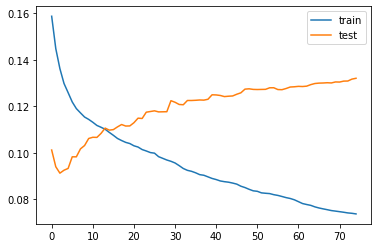

R2 score of the train set : 0.7576130198814338
R2 score of the train set : -0.037847710994001416
OSR2 : -0.21654478359557205


In [29]:
score = pd.DataFrame(score, columns = ["num_estimators", "max_depth", "alpha", "lambda","rmse"])
score.sort_values(by=['rmse'], ascending=False, inplace = True)
best_params = list(score.iloc[0, :])[:-1]
print(score.iloc[0, :])

evalset = [(encoder.transform(X_train), y_train), (encoder.transform(X_test),y_test)]
model = XGBRegressor(n_estimators = int(best_params[0]), max_depth = int(best_params[1]), reg_alpha = best_params[2], reg_lambda = best_params[3], eta = 0.3)
#init_lr = eta = best_params[5]
#callbacks = xgb.callback.LearningRateScheduler(lr_decay)
model.fit(encoder.transform(X_train), y_train, eval_set = evalset, verbose = 0)# , callbacks=[callbacks])
results = model.evals_result()
pyplot.plot(results['validation_0']['rmse'], label='train')
pyplot.plot(results['validation_1']['rmse'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print(f"R2 score of the train set : {r2_score(model.predict(encoder.transform(X_train)), y_train)}")
print(f"R2 score of the train set : {r2_score(model.predict(encoder.transform(X_test)), y_test)}")

osr = 1 - (sum([(list(model.predict(encoder.transform(X_test)))[k] - y_test[k])**2 for k in range(len(y_test))]))/(sum([(np.mean(y_train) - y_test[k])**2 for k in range(len(y_test))]))
print(f"OSR2 : {osr}")

###  NEW RF

In [75]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 30, min_samples_split = 5, min_samples_leaf = 5, max_features = 1)
model.fit(encoder.transform(X_train), y_train)# , callbacks=[callbacks])
print(f"R2 score of the train set : {r2_score(model.predict(encoder.transform(X_train)), y_train)}")
print(f"R2 score of the test set : {r2_score(model.predict(encoder.transform(X_test)), y_test)}")
print(f"OSR2 : {osr2(model.predict(encoder.transform(X_test)), y_test, y_train)}")

R2 score of the train set : -0.1626387737915307
R2 score of the test set : -1.3952212371303374
OSR2 : 0.3823813863557417


### Feature Importance

In [76]:
import time

import numpy as np

start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.004 seconds


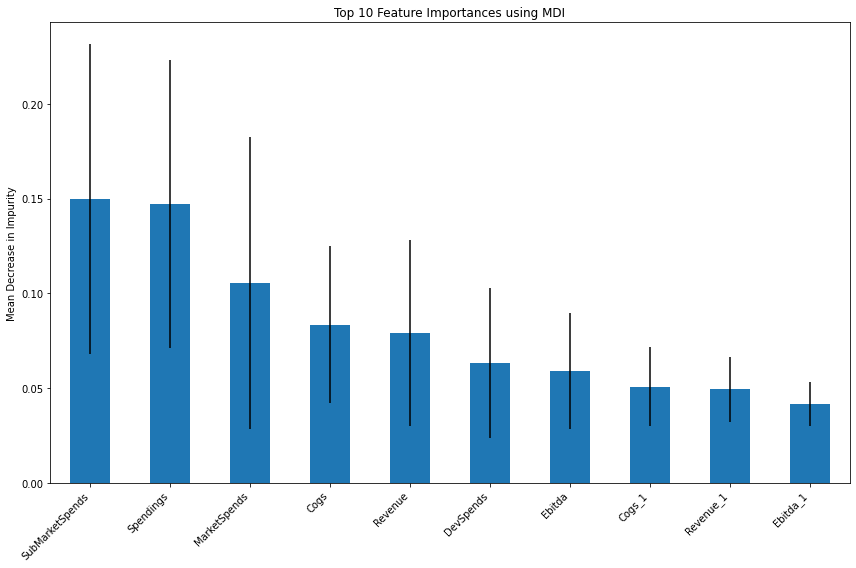

In [107]:
num_features_names = [x.replace('LogDiff', '') for x in num_features_names]
full_feature_names = list(feature_names) + list(num_features_names)
forest_importances = pd.Series(importances, index=full_feature_names)

# Select the top 10 features based on importances
top_features = forest_importances.nlargest(10)

# Make sure std is aligned with the index of top_features
std_series = pd.Series(std, index=full_feature_names)
std_for_top_features = std_series[top_features.index]

fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figsize as needed
top_features.plot.bar(yerr=std_for_top_features, ax=ax)

# Rotate x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_title("Top 10 Feature Importances using MDI")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()

plt.show()

In [111]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    model, encoder.transform(X_train).toarray(), y_train, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=full_feature_names)

Elapsed time to compute the importances: 7.720 seconds


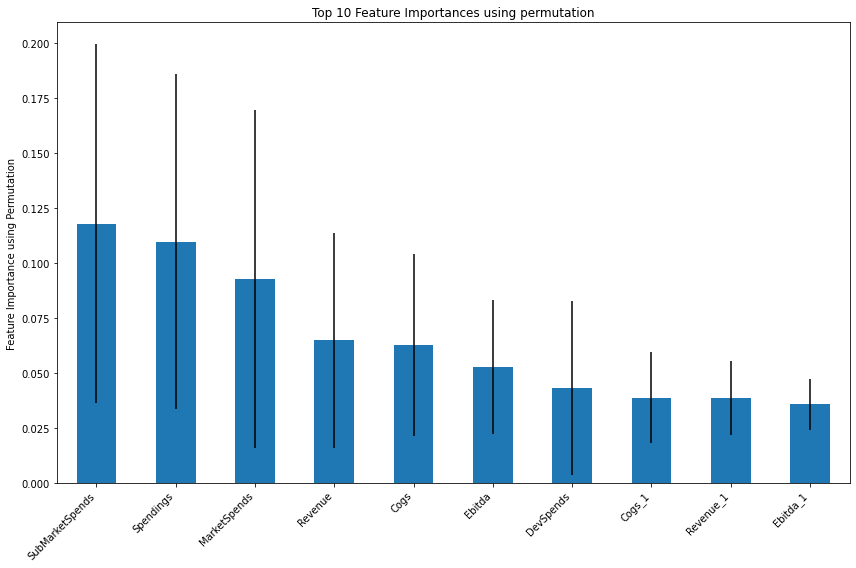

In [114]:
top_features = forest_importances.nlargest(10)

# Make sure std is aligned with the index of top_features
std_series = pd.Series(std, index=full_feature_names)
std_for_top_features = std_series[top_features.index]

fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figsize as needed
top_features.plot.bar(yerr=std_for_top_features, ax=ax)

# Rotate x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_title("Top 10 Feature Importances using permutation")
ax.set_ylabel("Feature Importance using Permutation")
fig.tight_layout()

plt.show()

### Pred

In [3]:
pred_df_rf = pd.read_csv("../clean_data/test_pred_rf_log.csv", index_col = 0)
pred_df_rf

,Company,Device,Market,SubMarket,Year,Pred
4,ABB,Amplifier/Comparator,Industrial,Power & Energy,2023,0.048614
5,ABB,Amplifier/Comparator,Industrial,Power & Energy,2024,0.000823
10,ABB,Analog Application Specific IC,Industrial,Power & Energy,2023,0.040655
11,ABB,Analog Application Specific IC,Industrial,Power & Energy,2024,0.035702
16,ABB,Data Converters,Industrial,Power & Energy,2023,0.073784
...,...,...,...,...,...,...
17253,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Enterprise/SOHO,2024,0.014851
17258,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2023,-0.030341
17259,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2024,-0.051406
17264,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2023,-0.054189


In [39]:
test_values = pd.read_csv("../clean_data/final_df.csv", index_col= 0)
test_values = df[(df.Year >= 2022)].iloc[:, :6]
test_values["Value"] = test_values.groupby(["Company", "Device", "Market", "SubMarket"])["Value"].shift(1)
test_values = test_values[~test_values['Value'].isnull()]
test_values

,Company,Device,Market,SubMarket,Year,Value
5,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2023,13.879158
6,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2024,16.234860
12,ABB,Amplifier/Comparator,Industrial,Power & Energy,2023,10.040442
13,ABB,Amplifier/Comparator,Industrial,Power & Energy,2024,10.927740
19,ABB,Analog Application Specific IC,Industrial,Manufacturing Equipment,2023,29.083150
...,...,...,...,...,...,...
27686,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Enterprise/SOHO,2024,6.047200
27692,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2023,2.291600
27693,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2024,2.249966
27699,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2023,1.229600


In [40]:
def inverselog(x, y):
    return ((y+1)*np.exp(x)) - 1

In [41]:
pred_df_rf = pd.read_csv("../clean_data/test_pred_rf_log.csv", index_col = 0)
pred_df_rf = pred_df_rf.merge(test_values, how="left", on = ["Company", "Device", "Market", "SubMarket", "Year"])
pred_df_rf["Spendings"] = pred_df_rf.apply(lambda x : inverselog(x.Pred, x.Value), axis = 1)
pred_df_rf["Value_2"] = pred_df_rf.groupby(["Company", "Device", "Market", "SubMarket"])["Spendings"].shift(1)
pred_df_rf["Value"] = np.where(pd.notna(pred_df_rf['Value_2']), pred_df_rf['Value_2'], pred_df_rf['Value'])
pred_df_rf.drop(["Spendings", "Value_2"], axis = 1, inplace = True)
pred_df_rf["Spendings"] = pred_df_rf.apply(lambda x : inverselog(x.Pred, x.Value), axis = 1)
pred_df_rf

,Company,Device,Market,SubMarket,Year,Pred,Value,Spendings
0,ABB,Amplifier/Comparator,Industrial,Power & Energy,2023,0.048614,10.040442,10.590418
1,ABB,Amplifier/Comparator,Industrial,Power & Energy,2024,0.000823,10.590418,10.599964
2,ABB,Analog Application Specific IC,Industrial,Power & Energy,2023,0.040655,29.153250,30.404392
3,ABB,Analog Application Specific IC,Industrial,Power & Energy,2024,0.035702,30.404392,31.545838
4,ABB,Data Converters,Industrial,Power & Energy,2023,0.073784,6.086300,6.628926
...,...,...,...,...,...,...,...,...
5740,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Enterprise/SOHO,2024,0.014851,5.931654,6.035363
5741,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2023,-0.030341,2.291600,2.193229
5742,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2024,-0.051406,2.193229,2.033227
5743,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2023,-0.054189,1.229600,1.111996


In [45]:
test_values = pd.read_csv("../clean_data/final_df.csv", index_col= 0)
test_values_array = list(test_values[(test_values.Year >= 2023)].Value)
test_values_array

[10.92774023083295,
 11.6598,
 33.3042,
 38.99815524467501,
 7.513800000000001,
 7.0639,
 36.70932020164034,
 42.215881899751096,
 37.98466869855693,
 46.1550721140325,
 0.410503647754032,
 0.4063999999999997,
 0.1052009348202779,
 0.1068999999999998,
 7.626667770915716,
 7.7205,
 0.8231070441941667,
 0.8203934507368319,
 0.5511047163836778,
 0.5753954065748086,
 4.389737567609202,
 4.9890601719540815,
 0.6286999999999998,
 0.6035963371341532,
 0.0878999999999998,
 0.0880994653769363,
 10.605,
 11.48813028539526,
 0.237995681442906,
 0.2298959644719056,
 0.3894929324454282,
 0.4022929382646701,
 3.102543702709078,
 3.250942933876319,
 0.4268999999999998,
 0.4507047299211852,
 0.6324999999999998,
 0.6852071909074688,
 4.5513,
 4.923351668118421,
 19.90674327157081,
 21.3301,
 11.4578,
 13.783669713475865,
 27.68095657256606,
 31.739341166569968,
 8.098399999999998,
 8.9818,
 11.8796,
 13.602043146161508,
 0.4612,
 0.4973,
 0.9214,
 1.0145,
 16.6647,
 18.2457,
 4.825,
 5.46,
 0.4223,
 0.

In [48]:
list(pred_df_rf.Spendings)

[10.59041766709522,
 10.5999639991304,
 30.404392075968,
 31.54583816143267,
 6.628926065495567,
 6.427307871269858,
 34.68469721535453,
 35.15572105555285,
 38.60648324568683,
 41.08413410338319,
 0.47621757174683776,
 0.5479306371618786,
 0.14798480566613192,
 0.17150719480283794,
 6.51021851223222,
 6.656928504760882,
 0.8911144793045929,
 1.0142892356714888,
 0.604119548442662,
 0.6698873625512696,
 4.099905476922141,
 4.414927382598503,
 0.6753237488733959,
 0.7419113985631931,
 0.11229772906321212,
 0.13043162678585807,
 9.974153415827326,
 10.462987020393772,
 0.2708050109575053,
 0.33791697610067617,
 0.44117547546171654,
 0.5230461610284038,
 2.9750335065896887,
 3.181490052430733,
 0.5182282365517543,
 0.6426293045770195,
 0.7727201064334666,
 0.8581533006271242,
 4.850547152835971,
 5.179283211112936,
 14.310181284392288,
 13.736590075139459,
 8.721440486699283,
 8.734354109780114,
 21.395646982947387,
 20.67674223860136,
 6.34562249675813,
 6.356469859825161,
 9.93445517545

In [47]:
print(mean_absolute_error(list(pred_df_rf.Spendings), test_values_array))

1.9004470558702995


0.9928775825980013

In [54]:
pred_df_xgb = pd.read_csv("../clean_data/test_pred_xgb_log.csv", index_col = 0)
pred_df_xgb = pred_df_xgb.merge(test_values, how="left", on = ["Company", "Device", "Market", "SubMarket", "Year"])
pred_df_xgb["Spendings"] = pred_df_xgb.apply(lambda x : inverselog(x.Pred, x.Value), axis = 1)
pred_df_xgb["Value_2"] = pred_df_xgb.groupby(["Company", "Device", "Market", "SubMarket"])["Spendings"].shift(1)
pred_df_xgb["Value"] = np.where(pd.notna(pred_df_xgb['Value_2']), pred_df_xgb['Value_2'], pred_df_xgb['Value'])
pred_df_xgb.drop(["Spendings", "Value_2"], axis = 1, inplace = True)
pred_df_xgb["Spendings"] = pred_df_xgb.apply(lambda x : inverselog(x.Pred, x.Value), axis = 1)
pred_df_xgb

,Company,Device,Market,SubMarket,Year,Pred,Value,Spendings
0,ABB,Amplifier/Comparator,Industrial,Power & Energy,2023,0.023099,10.040442,10.298428
1,ABB,Amplifier/Comparator,Industrial,Power & Energy,2024,-0.095778,10.298428,9.266497
2,ABB,Analog Application Specific IC,Industrial,Power & Energy,2023,0.034851,29.153250,30.222652
3,ABB,Analog Application Specific IC,Industrial,Power & Energy,2024,-0.037900,30.222652,29.061456
4,ABB,Data Converters,Industrial,Power & Energy,2023,0.088769,6.086300,6.744111
...,...,...,...,...,...,...,...,...
5740,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Enterprise/SOHO,2024,-0.006266,6.119535,6.075064
5741,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2023,-0.046026,2.291600,2.143533
5742,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2024,-0.181279,2.143533,1.622343
5743,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2023,0.023227,1.229600,1.281993


In [56]:
test_values = pd.read_csv("../clean_data/final_df.csv", index_col= 0)
test_values_array = list(test_values[(test_values.Year >= 2023)].Value)

In [57]:
mean_absolute_error(list(pred_df_xgb.Spendings), test_values_array)

2.830604637064221

# Prediction 2025-2027

### Model Classique

In [124]:
df = pd.read_csv("../clean_data/final_df.csv", index_col= 0)
df[(df.Company == "ASML")]

,Company,Device,Market,SubMarket,Year,Value,Spendings,MarketSpends,SubMarketSpends,DevSpends,Cogs,Cogs_1,Cogs_2,Revenue,Revenue_1,Revenue_2,Ebitda,Ebitda_1,Ebitda_2
140,ASML,Amplifier/Comparator,Industrial,Test & Measurement,2018,6.844200,343.383,11486.855,1355.361,3990.996,6275.650000,5244.030000,3957.35,11611.70,9509.50,7294.5,3590.90,3027.50,2241.7
141,ASML,Amplifier/Comparator,Industrial,Test & Measurement,2019,6.445140,321.595,10750.418,1268.352,3800.001,6939.200000,6275.650000,5244.03,12541.10,11611.70,9509.5,14831.30,3590.90,3027.5
142,ASML,Amplifier/Comparator,Industrial,Test & Measurement,2020,7.230800,316.085,10966.167,1257.063,3786.004,7619.420000,6939.200000,6275.65,14831.30,12541.10,11611.7,4802.90,14831.30,3590.9
143,ASML,Amplifier/Comparator,Industrial,Test & Measurement,2021,12.455156,413.487,13599.835,1598.296,4785.001,9338.990000,7619.420000,6939.20,19746.40,14831.30,12541.1,7328.20,4802.90,14831.3
144,ASML,Amplifier/Comparator,Industrial,Test & Measurement,2022,13.121200,464.215,15244.412,1809.011,5469.003,11112.250000,9338.990000,7619.42,22465.10,19746.40,14831.3,7424.50,7328.20,4802.9
145,ASML,Amplifier/Comparator,Industrial,Test & Measurement,2023,19.906743,579.734,16317.564,2047.593,5133.007,4229.644286,11112.250000,9338.99,28836.96,22465.10,19746.4,10132.18,7424.50,7328.2
146,ASML,Amplifier/Comparator,Industrial,Test & Measurement,2024,21.330100,585.225,17578.984,2216.472,5225.000,4705.661786,4229.644286,11112.25,29189.56,28836.96,22465.1,10313.60,10132.18,7424.5
147,ASML,Analog Application Specific IC,Industrial,Test & Measurement,2018,3.640269,183.722,11486.855,1355.361,39283.995,6275.650000,5244.030000,3957.35,11611.70,9509.50,7294.5,3590.90,3027.50,2241.7
148,ASML,Analog Application Specific IC,Industrial,Test & Measurement,2019,3.449828,170.415,10750.418,1268.352,36867.003,6939.200000,6275.650000,5244.03,12541.10,11611.70,9509.5,14831.30,3590.90,3027.5
149,ASML,Analog Application Specific IC,Industrial,Test & Measurement,2020,3.908373,172.428,10966.167,1257.063,40487.011,7619.420000,6939.200000,6275.65,14831.30,12541.10,11611.7,4802.90,14831.30,3590.9


In [127]:
prediction_df = pd.read_csv("../clean_data/prediction_df.csv", index_col = 0)
prediction_df = prediction_df[(prediction_df.Company == 'Facebook (Meta)') | (prediction_df.Company == 'ASML')].reset_index(drop = True)
prediction_df = prediction_df[["Company", "Year", "Device", "Market", "SubMarket", "Spendings", "MarketSpends", "SubMarketSpends", "DevSpends", "Cogs", "Cogs_1", "Cogs_2", "Ebitda", "Ebitda_1", "Ebitda_2", "Revenue", "Revenue_1", "Revenue_2"]]
prediction_df[(prediction_df.Company == "ASML")]

,Company,Year,Device,Market,SubMarket,Spendings,MarketSpends,SubMarketSpends,DevSpends,Cogs,Cogs_1,Cogs_2,Ebitda,Ebitda_1,Ebitda_2,Revenue,Revenue_1,Revenue_2
0,ASML,2025,Amplifier/Comparator,Industrial,Test & Measurement,602.270,18718.436,2345.946,5641.009,5181.679286,4705.661786,4229.644286,14127.01,10313.60,10132.18,35325.67,29189.56,28836.96
1,ASML,2026,Amplifier/Comparator,Industrial,Test & Measurement,637.541,20062.488,2483.707,5829.007,5657.696786,5181.679286,4705.661786,17311.87,14127.01,10313.60,39425.96,35325.67,29189.56
2,ASML,2027,Amplifier/Comparator,Industrial,Test & Measurement,662.350,21590.113,2580.325,6035.001,6133.714286,5657.696786,5181.679286,19784.03,17311.87,14127.01,41619.77,39425.96,35325.67
3,ASML,2025,Analog Application Specific IC,Industrial,Test & Measurement,344.412,18718.436,2345.946,57413.002,5181.679286,4705.661786,4229.644286,14127.01,10313.60,10132.18,35325.67,29189.56,28836.96
4,ASML,2026,Analog Application Specific IC,Industrial,Test & Measurement,370.687,20062.488,2483.707,58899.008,5657.696786,5181.679286,4705.661786,17311.87,14127.01,10313.60,39425.96,35325.67,29189.56
5,ASML,2027,Analog Application Specific IC,Industrial,Test & Measurement,385.111,21590.113,2580.325,60721.007,6133.714286,5657.696786,5181.679286,19784.03,17311.87,14127.01,41619.77,39425.96,35325.67
6,ASML,2025,Data Converters,Industrial,Test & Measurement,856.803,18718.436,2345.946,5429.006,5181.679286,4705.661786,4229.644286,14127.01,10313.60,10132.18,35325.67,29189.56,28836.96
7,ASML,2026,Data Converters,Industrial,Test & Measurement,916.124,20062.488,2483.707,5610.002,5657.696786,5181.679286,4705.661786,17311.87,14127.01,10313.60,39425.96,35325.67,29189.56
8,ASML,2027,Data Converters,Industrial,Test & Measurement,951.772,21590.113,2580.325,5810.011,6133.714286,5657.696786,5181.679286,19784.03,17311.87,14127.01,41619.77,39425.96,35325.67
9,ASML,2025,Interface,Industrial,Test & Measurement,223.000,18718.436,2345.946,4593.011,5181.679286,4705.661786,4229.644286,14127.01,10313.60,10132.18,35325.67,29189.56,28836.96


In [122]:
pred_df = prediction_df.copy()
comp_df = pred_df[["Company", "Market", "SubMarket", "Device", "Year"]]
pred_df.drop(["Company", "Year"], axis = 1, inplace = True)
pred = model.predict(encoder.transform(pred_df))
comp_df["Pred"] = pred
comp_df

<ipython-input-122-c06d413dd973>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df["Pred"] = pred


,Company,Market,SubMarket,Device,Year,Pred
0,ASML,Industrial,Test & Measurement,Amplifier/Comparator,2025,14.576051
1,ASML,Industrial,Test & Measurement,Amplifier/Comparator,2026,15.216901
2,ASML,Industrial,Test & Measurement,Amplifier/Comparator,2027,16.594269
3,ASML,Industrial,Test & Measurement,Analog Application Specific IC,2025,17.124908
4,ASML,Industrial,Test & Measurement,Analog Application Specific IC,2026,17.765759
5,ASML,Industrial,Test & Measurement,Analog Application Specific IC,2027,16.579649
6,ASML,Industrial,Test & Measurement,Data Converters,2025,17.522520
7,ASML,Industrial,Test & Measurement,Data Converters,2026,18.163372
8,ASML,Industrial,Test & Measurement,Data Converters,2027,17.893154
9,ASML,Industrial,Test & Measurement,Interface,2025,7.447702


In [83]:
comp_df.to_csv("../clean_data/pred_meta_asml.csv")

### New target

In [19]:
df = pd.read_csv("../clean_data/newtarget_df.csv", index_col= 0)
df.drop(["Company", "Region"], axis = 1, inplace = True )

In [21]:
first_df = df[(df.Year <= 2022)]
y_train = np.array(first_df.Target)
X_train = first_df.drop(["Target", "Year"], axis = 1)
second_df = df[(df.Year >= 2023)]
y_test = np.array(second_df.Target)
X_test = second_df.drop(["Target", "Year"], axis = 1)

In [22]:
cat = ["Device", "Market", "SubMarket"]
full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat)], remainder='passthrough')
encoder = full_pipeline.fit(X_train)

In [26]:
prediction_df = pd.read_csv("../clean_data/new_pred.csv", index_col = 0)
prediction_df.reset_index(drop = True, inplace = True)

In [24]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 30, min_samples_split = 5, min_samples_leaf = 5, max_features = 1)
model.fit(encoder.transform(X_train), y_train)# , callbacks=[callbacks])
#print(f"R2 score of the train set : {r2_score(model.predict(encoder.transform(X_train)), y_train)}")
#print(f"R2 score of the test set : {r2_score(model.predict(encoder.transform(X_test)), y_test)}")
#print(f"OSR2 : {osr2(model.predict(encoder.transform(X_test)), y_test, y_train)}")

RandomForestRegressor(max_features=1, min_samples_leaf=5, min_samples_split=5,
                      n_estimators=30)

In [88]:
prediction_df[(prediction_df.Year == 2025) & (prediction_df.Company == "ASML")]

,Company,Device,Market,SubMarket,Year,LogDiffSpendings,LogDiffMarketSpends,LogDiffSubMarketSpends,LogDiffDevSpends,LogDiffCogs,LogDiffRevenue,LogDiffEbitda,LogDiffCogs_1,LogDiffRevenue_1,LogDiffEbitda_1
90,ASML,Amplifier/Comparator,Industrial,Manufacturing Equipment,2025,-0.037964,0.062801,0.014396,0.076594,0.096343,0.190793,0.314599,0.106625,0.012153,0.017745
93,ASML,Amplifier/Comparator,Industrial,Test & Measurement,2025,0.028661,0.062801,0.056747,0.076594,0.096343,0.190793,0.314599,0.106625,0.012153,0.017745
96,ASML,Analog Application Specific IC,Industrial,Manufacturing Equipment,2025,0.018472,0.062801,0.014396,0.099891,0.096343,0.190793,0.314599,0.106625,0.012153,0.017745
99,ASML,Analog Application Specific IC,Industrial,Test & Measurement,2025,0.090186,0.062801,0.056747,0.099891,0.096343,0.190793,0.314599,0.106625,0.012153,0.017745
102,ASML,Data Converters,Industrial,Manufacturing Equipment,2025,-0.140537,0.062801,0.014396,0.076719,0.096343,0.190793,0.314599,0.106625,0.012153,0.017745
105,ASML,Data Converters,Industrial,Test & Measurement,2025,0.080438,0.062801,0.056747,0.076719,0.096343,0.190793,0.314599,0.106625,0.012153,0.017745
108,ASML,Interface,Industrial,Manufacturing Equipment,2025,0.034026,0.062801,0.014396,0.081607,0.096343,0.190793,0.314599,0.106625,0.012153,0.017745
111,ASML,Interface,Industrial,Test & Measurement,2025,0.045670,0.062801,0.056747,0.081607,0.096343,0.190793,0.314599,0.106625,0.012153,0.017745
114,ASML,Voltage Regulator/Reference,Industrial,Manufacturing Equipment,2025,0.041819,0.062801,0.014396,0.085213,0.096343,0.190793,0.314599,0.106625,0.012153,0.017745
117,ASML,Voltage Regulator/Reference,Industrial,Test & Measurement,2025,0.019992,0.062801,0.056747,0.085213,0.096343,0.190793,0.314599,0.106625,0.012153,0.017745


In [57]:
pred_df = prediction_df.copy()
comp_df = pred_df[["Company", "Market", "SubMarket", "Device", "Year"]]
pred_df.drop(["Company", "Year"], axis = 1, inplace = True)
pred = model.predict(encoder.transform(pred_df))
comp_df["Pred"] = pred
comp_df

<ipython-input-57-c06d413dd973>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df["Pred"] = pred


,Company,Market,SubMarket,Device,Year,Pred
0,ABB,Industrial,Manufacturing Equipment,Amplifier/Comparator,2025,0.016375
1,ABB,Industrial,Manufacturing Equipment,Amplifier/Comparator,2026,0.020206
2,ABB,Industrial,Manufacturing Equipment,Amplifier/Comparator,2027,0.022306
3,ABB,Industrial,Power & Energy,Amplifier/Comparator,2025,0.014634
4,ABB,Industrial,Power & Energy,Amplifier/Comparator,2026,0.026254
...,...,...,...,...,...,...
9267,Zebra Technologies,Wireless Communications,Infrastructure,Voltage Regulator/Reference,2026,-0.008654
9268,Zebra Technologies,Wireless Communications,Infrastructure,Voltage Regulator/Reference,2027,-0.010039
9269,Zebra Technologies,Wireless Communications,Other Wireless,Voltage Regulator/Reference,2025,0.036562
9270,Zebra Technologies,Wireless Communications,Other Wireless,Voltage Regulator/Reference,2026,0.010711


In [95]:
comp_df[(comp_df.Company == "Acer") & (comp_df.Device == "Amplifier/Comparator")]

,Company,Market,SubMarket,Device,Year,Pred
165,Acer,Computer Peripherals & Storage,Other Peripherals,Amplifier/Comparator,2025,0.019015
166,Acer,Computer Peripherals & Storage,Other Peripherals,Amplifier/Comparator,2026,-0.011098
167,Acer,Computer Peripherals & Storage,Other Peripherals,Amplifier/Comparator,2027,-0.004516
168,Acer,Computer Peripherals & Storage,Other Storage,Amplifier/Comparator,2025,-0.037701
169,Acer,Computer Peripherals & Storage,Other Storage,Amplifier/Comparator,2026,-0.050783
170,Acer,Computer Peripherals & Storage,Other Storage,Amplifier/Comparator,2027,-0.058296
171,Acer,Computer Platforms,Data Center Servers,Amplifier/Comparator,2025,-0.025407
172,Acer,Computer Platforms,Data Center Servers,Amplifier/Comparator,2026,-0.044064
173,Acer,Computer Platforms,Data Center Servers,Amplifier/Comparator,2027,0.004223
174,Acer,Computer Platforms,Desktop PCs,Amplifier/Comparator,2025,-0.019139


In [32]:
test_values = pd.read_csv("../clean_data/final_df.csv", index_col= 0)
test_values

,Company,Device,Market,SubMarket,Year,Value,Region,Spendings,MarketSpends,SubMarketSpends,DevSpends,Cogs,Cogs_1,Cogs_2,Revenue,Revenue_1,Revenue_2,Ebitda,Ebitda_1,Ebitda_2
0,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2018,7.951500,AmericasAsia & Oceania (exc. Japan)EMEAJapan,82.904,11486.855,926.369,3990.996,19059.000000,17278.000000,17270.0,27662.00,25196.00,24929.0,3227.000000,2929.000000,2987.0
1,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2019,8.616500,AmericasAsia & Oceania (exc. Japan)EMEAJapan,84.255,10750.418,905.298,3800.001,19018.000000,19059.000000,17278.0,27978.00,27662.00,25196.0,3347.000000,3227.000000,2929.0
2,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2020,8.565350,AmericasAsia & Oceania (exc. Japan)EMEAJapan,85.306,10966.167,942.751,3786.004,18123.000000,19018.000000,19059.0,26134.00,27978.00,27662.0,2668.000000,3347.000000,3227.0
3,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2021,12.353845,AmericasAsia & Oceania (exc. Japan)EMEAJapan,122.722,13599.835,1128.090,4785.001,19407.000000,18123.000000,19018.0,28945.00,26134.00,27978.0,4641.000000,2668.000000,3347.0
4,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2022,13.879158,AmericasAsia & Oceania (exc. Japan)EMEAJapan,138.207,15244.412,1221.082,5469.003,19712.000000,19407.000000,18123.0,29446.00,28945.00,26134.0,4477.000000,4641.000000,2668.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27696,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2020,0.809700,AmericasAsia & Oceania (exc. Japan)EMEAJapanAm...,454.000,25838.124,4852.175,11956.010,2445.000000,2385.000000,2237.0,4448.00,4485.00,4218.0,831.000000,899.000000,817.0
27697,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2021,1.271038,AmericasAsia & Oceania (exc. Japan)EMEAJapanAm...,584.000,33129.151,5885.459,15765.008,2999.000000,2445.000000,2385.0,5627.00,4448.00,4485.0,1198.000000,831.000000,899.0
27698,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2022,1.229600,AmericasAsia & Oceania (exc. Japan)EMEAJapanAm...,555.000,37356.594,5729.355,17307.004,3157.000000,2999.000000,2445.0,5781.00,5627.00,4448.0,1140.000000,1198.000000,831.0
27699,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2023,1.182734,AmericasAsia & Oceania (exc. Japan)EMEAJapanAm...,474.999,28959.587,4701.997,16419.001,7385.362857,3157.000000,2999.0,4536.76,5781.00,5627.0,3668.885714,1140.000000,1198.0


In [82]:
test_values_pred = pd.read_csv("../clean_data/final_df.csv", index_col= 0)
test_values_pred = df[(df.Year <= 2024)].iloc[:, :6]
test_values_pred

,Company,Device,Market,SubMarket,Year,Value
0,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2018,7.951500
1,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2019,8.616500
2,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2020,8.565350
3,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2021,12.353845
4,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2022,13.879158
...,...,...,...,...,...,...
27696,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2020,0.809700
27697,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2021,1.271038
27698,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2022,1.229600
27699,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2023,1.182734


In [43]:
test_values_pred = pd.read_csv("../clean_data/final_df.csv", index_col= 0)
test_values_pred = df[(df.Year == 2024)].iloc[:, :6]
#test_values_pred["Value_1"] = test_values_pred.groupby(["Company", "Device", "Market", "SubMarket"])["Value"].shift(-1)
#test_values_pred = test_values_pred[~test_values_pred['Value'].isnull()]
test_values_pred

,Company,Device,Market,SubMarket,Year,Value
6,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2024,15.408600
13,ABB,Amplifier/Comparator,Industrial,Power & Energy,2024,11.659800
20,ABB,Analog Application Specific IC,Industrial,Manufacturing Equipment,2024,31.593545
27,ABB,Analog Application Specific IC,Industrial,Power & Energy,2024,38.998155
34,ABB,Data Converters,Industrial,Manufacturing Equipment,2024,22.114800
...,...,...,...,...,...,...
27672,Zebra Technologies,Voltage Regulator/Reference,Computer Platforms,Tablet PCs,2024,7.356100
27679,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Carrier,2024,5.591700
27686,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Enterprise/SOHO,2024,6.380500
27693,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2024,2.293834


In [78]:
test_values_pred_2025 = test_values_pred.copy()
test_values_pred_2025.Year = 2025
comp_df2025  = comp_df[comp_df.Year == 2025]
comp_df2025
test_values_pred_2025 = test_values_pred_2025.merge(comp_df2025, how = 'left', on = ["Company", "Device", "Market", "SubMarket", "Year"])
test_values_pred_2025.dropna(inplace = True)
test_values_pred_2025['Value'] = test_values_pred_2025.apply(lambda x : inverselog(x.Pred, x.Value), axis = 1)
test_values_pred_2025.drop("Pred", axis = 1, inplace = True)
test_values_pred_2025

,Company,Device,Market,SubMarket,Year,Value
0,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2025,15.679504
1,ABB,Amplifier/Comparator,Industrial,Power & Energy,2025,11.846428
2,ABB,Analog Application Specific IC,Industrial,Manufacturing Equipment,2025,31.913214
3,ABB,Analog Application Specific IC,Industrial,Power & Energy,2025,40.763506
4,ABB,Data Converters,Industrial,Manufacturing Equipment,2025,22.432244
...,...,...,...,...,...,...
3102,Zebra Technologies,Voltage Regulator/Reference,Computer Platforms,Tablet PCs,2025,7.199977
3103,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Carrier,2025,6.477209
3104,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Enterprise/SOHO,2025,7.228420
3105,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2025,2.340390


In [79]:
test_values_pred_2026 = test_values_pred_2025.copy()
test_values_pred_2026.Year = 2026
comp_df2026  = comp_df[comp_df.Year == 2026]
comp_df2026
test_values_pred_2026 = test_values_pred_2026.merge(comp_df2026, how = 'left', on = ["Company", "Device", "Market", "SubMarket", "Year"])
test_values_pred_2026.dropna(inplace = True)
test_values_pred_2026['Value'] = test_values_pred_2026.apply(lambda x : inverselog(x.Pred, x.Value), axis = 1)
test_values_pred_2026.drop("Pred", axis = 1, inplace = True)
test_values_pred_2026

,Company,Device,Market,SubMarket,Year,Value
0,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2026,16.019962
1,ABB,Amplifier/Comparator,Industrial,Power & Energy,2026,12.188162
2,ABB,Analog Application Specific IC,Industrial,Manufacturing Equipment,2026,33.006412
3,ABB,Analog Application Specific IC,Industrial,Power & Energy,2026,44.007083
4,ABB,Data Converters,Industrial,Manufacturing Equipment,2026,23.030456
...,...,...,...,...,...,...
3092,Zebra Technologies,Voltage Regulator/Reference,Computer Platforms,Tablet PCs,2026,7.193278
3093,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Carrier,2026,7.416403
3094,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Enterprise/SOHO,2026,7.789191
3095,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2026,2.311608


In [80]:
test_values_pred_2027 = test_values_pred_2026.copy()
test_values_pred_2027.Year = 2027
comp_df2027  = comp_df[comp_df.Year == 2027]
comp_df2027
test_values_pred_2027 = test_values_pred_2027.merge(comp_df2027, how = 'left', on = ["Company", "Device", "Market", "SubMarket", "Year"])
test_values_pred_2027.dropna(inplace = True)
test_values_pred_2027['Value'] = test_values_pred_2027.apply(lambda x : inverselog(x.Pred, x.Value), axis = 1)
test_values_pred_2027.drop("Pred", axis = 1, inplace = True)
test_values_pred_2027

,Company,Device,Market,SubMarket,Year,Value
0,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2027,16.403868
1,ABB,Amplifier/Comparator,Industrial,Power & Energy,2027,12.501288
2,ABB,Analog Application Specific IC,Industrial,Manufacturing Equipment,2027,34.116424
3,ABB,Analog Application Specific IC,Industrial,Power & Energy,2027,45.389611
4,ABB,Data Converters,Industrial,Manufacturing Equipment,2027,23.692109
...,...,...,...,...,...,...
3077,Zebra Technologies,Voltage Regulator/Reference,Computer Platforms,Tablet PCs,2027,7.290728
3078,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Carrier,2027,8.493783
3079,Zebra Technologies,Voltage Regulator/Reference,Wired Communications,Enterprise/SOHO,2027,8.130329
3080,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Infrastructure,2027,2.278529


In [84]:
final_pred = pd.concat([test_values_pred, test_values_pred_2025, test_values_pred_2026, test_values_pred_2027], axis = 0, ignore_index = True)
final_pred.sort_values(["Company", "Device", "Market", "SubMarket", "Year"], inplace = True)
final_pred

,Company,Device,Market,SubMarket,Year,Value
0,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2018,7.951500
1,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2019,8.616500
2,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2020,8.565350
3,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2021,12.353845
4,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2022,13.879158
...,...,...,...,...,...,...
21853,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2023,1.182734
21854,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2024,1.173666
24951,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2025,1.254612
28033,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2026,1.278890


In [96]:
final_pred.reset_index(drop = True, inplace = True)

In [102]:
final_pred[final_pred.Value < 0]

,Company,Device,Market,SubMarket,Year,Value


In [101]:
final_pred.Value = final_pred.Value.apply(lambda x : max([x, 0]))
final_pred

,Company,Device,Market,SubMarket,Year,Value
0,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2018,7.951500
1,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2019,8.616500
2,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2020,8.565350
3,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2021,12.353845
4,ABB,Amplifier/Comparator,Industrial,Manufacturing Equipment,2022,13.879158
...,...,...,...,...,...,...
31111,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2023,1.182734
31112,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2024,1.173666
31113,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2025,1.254612
31114,Zebra Technologies,Voltage Regulator/Reference,Wireless Communications,Other Wireless,2026,1.278890


In [103]:
final_pred.to_csv("../clean_data/all_companies_pred.csv")

In [91]:
final_pred[final_pred.Company == "Facebook (Meta)"].groupby(["Company","Year"]).sum("Value")

Value
Company         Year           
Facebook (Meta) 2018  23.826800
                2019  27.916500
                2020  38.444600
                2021  75.023500
                2022  72.745800
                2023  66.859300
                2024  66.683400
                2025  70.113370
                2026  69.580505
                2027  68.821704

In [ ]:
def inverselog(x, y):
    return ((y+1)*np.exp(x)) - 1

In [ ]:
pred_df_rf = pred_df_rf.merge(test_values, how="left", on = ["Company", "Device", "Market", "SubMarket", "Year"])
pred_df_rf["Spendings"] = pred_df_rf.apply(lambda x : inverselog(x.Pred, x.Value), axis = 1)
pred_df_rf["Value_2"] = pred_df_rf.groupby(["Company", "Device", "Market", "SubMarket"])["Spendings"].shift(1)
pred_df_rf["Value"] = np.where(pd.notna(pred_df_rf['Value_2']), pred_df_rf['Value_2'], pred_df_rf['Value'])
pred_df_rf.drop(["Spendings", "Value_2"], axis = 1, inplace = True)
pred_df_rf["Spendings"] = pred_df_rf.apply(lambda x : inverselog(x.Pred, x.Value), axis = 1)
pred_df_rf

# Changement Dataset for IAI

In [50]:
df = pd.read_csv("../clean_data/final_df.csv", index_col= 0)
df.drop(["Company"], axis = 1, inplace = True)
cols = df.columns.to_list()
cols.pop(4)
cols += ["Value"]
df = df[cols]
df_train = df[(df.Year <= 2022)]
df_test = df[(df.Year > 2022)]
df_train.drop(["Year"], axis = 1, inplace = True)
df_test.drop(["Year"], axis = 1, inplace = True)
df_train.to_csv("IAI_train2.csv")
df_test.to_csv("IAI_test2.csv")

/var/folders/px/tjlhxsg56bg6d74d3c4cnhrc0000gn/T/ipykernel_56238/2313071825.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["Year"], axis = 1, inplace = True)
/var/folders/px/tjlhxsg56bg6d74d3c4cnhrc0000gn/T/ipykernel_56238/2313071825.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["Year"], axis = 1, inplace = True)
